In [1]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

import functions.eddy_feedback as ef
import functions.data_wrangling as data

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")

### Import datasets

Here want to compare the same models that have different resolutions. So that is
- HadGEM3-GC31-MM vs HadGEM3-GC31-LL
- OpenIFS-159 vs OpenIFS-511
- We also want to have a look at the PAMIP experiments that simulate El Nino

**NOTE**: Here I am using the non-regridded datasets.

In [2]:
# set paths and use Path class
mother_path = Path('/home/links/ct715/data_storage/PAMIP/monthly/1.1_pdSST-pdSIC/OpenIFS')

In [3]:
# Import required datasets into a dictionary
model_list = ['OpenIFS-T159', 'OpenIFS-T1279']
ds = {}
for model in model_list:
    
    # define directory for each model
    file_dir = mother_path.glob(f'{model}*.nc')
    
    # import dataset for each model
    dataset = xr.open_mfdataset(
        file_dir,
        parallel=True,
        chunks={'time': 31}
    )
    
    ds[model] = dataset

### Calculations

- Calculate EFP for later use and also ensure data is correct and matches previous results.
- Calculate seasonal means for winter in both hemispheres

In [4]:
# calculate EFP for each model and save to dictionary
efp_values = {}
for model in model_list:
    
    # calculate EFP
    efp_NH = ef.calculate_efp(ds[model], data_type='pamip')
    efp_SH = ef.calculate_efp(ds[model], data_type='pamip', calc_south_hemis=True)
    
    # save value into a dict of dictionaries 
    efp_values[model] = {
        'NH': efp_NH,
        'SH': efp_SH
    }
efp_values

{'OpenIFS-T159': {'NH': 0.0056, 'SH': 0.0026},
 'OpenIFS-T1279': {'NH': 0.0079, 'SH': 0.008}}

In [5]:
# calculate djf seasonal mean
models_djf = {}
models_jas = {}
for model in model_list:
    
    # calc seasonal mean for each dataset
    djf_mean = data.seasonal_mean(ds[model], season='djf')
    # save to dict
    models_djf[model] = djf_mean
    
    # calc seasonal mean for each dataset
    jas_mean = data.seasonal_mean(ds[model], season='jas')
    # save to dict
    models_jas[model] = jas_mean

### Perform data wrangling

- Need to ensure datasets have consistent coordinates, therefore interpolate the larger dataset to match the smaller one.

In [6]:
models_djf['OpenIFS-T1279'] = models_djf['OpenIFS-T1279'].interp(lat=models_djf['OpenIFS-T159'].lat.values)
models_djf['OpenIFS-T1279']

<xarray.Dataset>
Dimensions:  (time: 1, ens_ax: 99, level: 13, lat: 160, lon: 960)
Coordinates:
  * level    (level) float64 1e+03 700.0 500.0 400.0 ... 50.0 30.0 20.0 10.0
  * lon      (lon) float64 0.0 0.375 0.75 1.125 1.5 ... 358.5 358.9 359.2 359.6
  * time     (time) object 2000-12-01 00:00:00
  * lat      (lat) float64 -89.44 -88.31 -87.19 -86.06 ... 87.19 88.31 89.44
Dimensions without coordinates: ens_ax
Data variables:
    epfy     (time, ens_ax, level, lat) float64 dask.array<chunksize=(1, 99, 13, 160), meta=np.ndarray>
    epfz     (time, ens_ax, level, lat) float64 dask.array<chunksize=(1, 99, 13, 160), meta=np.ndarray>
    ua       (time, ens_ax, level, lat, lon) float32 dask.array<chunksize=(1, 99, 13, 160, 960), meta=np.ndarray>
    divFy    (time, ens_ax, level, lat) float64 dask.array<chunksize=(1, 99, 13, 160), meta=np.ndarray>
    ubar     (time, ens_ax, level, lat) float32 dask.array<chunksize=(1, 99, 13, 160), meta=np.ndarray>

In [7]:
# calculate difference for HadGEM models for winter in both hemispheres
hadgem_diff_NH = models_djf['OpenIFS-T1279'].mean(('time', 'ens_ax')) - models_djf['OpenIFS-T159'].mean(('time', 'ens_ax'))
hadgem_diff_SH = models_jas['OpenIFS-T1279'].mean(('time', 'ens_ax')) - models_jas['OpenIFS-T159'].mean(('time', 'ens_ax'))

# subset data
hadgem_diff_NH = hadgem_diff_NH.sel(lat=slice(20,85))
hadgem_diff_SH = hadgem_diff_SH.sel(lat=slice(-80,-20))
hadgem_diff_NH = hadgem_diff_NH.sel(level=slice(1000., 100))
hadgem_diff_SH = hadgem_diff_SH.sel(level=slice(1000., 100))

# # calculate difference for IFS models for winter in both hemispheres
# IFS_diff_NH = models_djf['OpenIFS-159'].mean(('time', 'ens_ax')) - models_djf['OpenIFS-511'].mean(('time', 'ens_ax'))
# IFS_diff_SH = models_jas['OpenIFS-159'].mean(('time', 'ens_ax')) - models_jas['OpenIFS-511'].mean(('time', 'ens_ax'))
# IFS_diff_NH = IFS_diff_NH.sel(lat=slice(0,90))
# IFS_diff_SH = IFS_diff_SH.sel(lat=slice(-90,0))

# Plot differences

### Difference for ubar and divFy

I want to have a look at the individual components and compare them between resolutions.

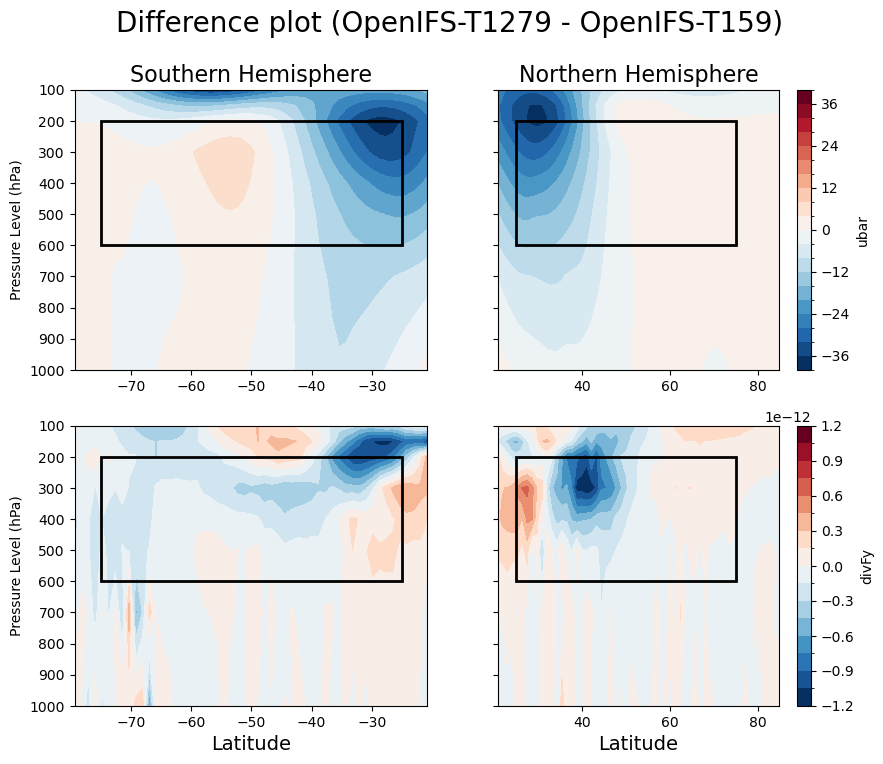

In [8]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,8), sharey=True)
# colour_bar = np.linspace(-5e-5, 5e-5, 21)
colour_bar = 20

hadgem_diff_SH.ubar.plot.contourf(levels=20, yincrease=False, ax=axes[0,0], add_colorbar=False)
hadgem_diff_SH.divFy.plot.contourf(levels=colour_bar, yincrease=False, ax=axes[1,0], add_colorbar=False)
hadgem_diff_NH.ubar.plot.contourf(levels=20, yincrease=False, ax=axes[0,1])
hadgem_diff_NH.divFy.plot.contourf(levels=colour_bar, yincrease=False, ax=axes[1,1])

# set titles
axes[0,0].set_title(f'Southern Hemisphere', fontsize=16)
axes[1,0].set_title('')
axes[0,1].set_title(f'Northern Hemisphere', fontsize=16)
axes[1,1].set_title('')

# set axes titles
axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')
axes[1,1].set_ylabel('')

# bottom row changes
for ax in axes[1,:]:
    ax.set_xlabel('Latitude', fontsize=14)

# plot rectangle
# Define rectangles and add them to each subplot
for ax in axes[:,0]:
    ax.set_ylabel('Pressure Level (hPa)')
    rect = patches.Rectangle((-75, 600.), 50, -400, fill=False, linewidth=2)
    ax.add_patch(rect)
for ax in axes[:,1]:
    rect = patches.Rectangle((25, 600.), 50, -400, fill=False, linewidth=2)
    ax.add_patch(rect)
    

fig.suptitle('Difference plot (OpenIFS-T1279 - OpenIFS-T159)', fontsize=20)

plt.tight_layout
plt.show()

***

# Troubleshooting

# Plot models individually

In [9]:
t1279 = ds['OpenIFS-T1279']
t159 = ds['OpenIFS-T159']

t1279_djf = models_djf['OpenIFS-T1279']
t159_djf = models_djf['OpenIFS-T159']

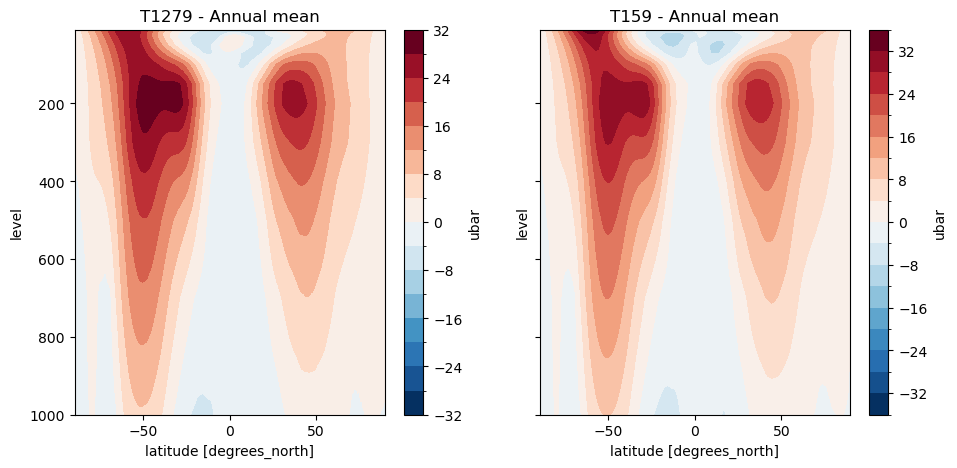

In [10]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(11,5))

t1279.ubar.mean(('time', 'ens_ax')).plot.contourf(levels=20, yincrease=False, ax=axes[0])
t159.ubar.mean(('time', 'ens_ax')).plot.contourf(levels=20, yincrease=False, ax=axes[1])
axes[0].set_title('T1279 - Annual mean')
axes[1].set_title('T159 - Annual mean')
plt.show()

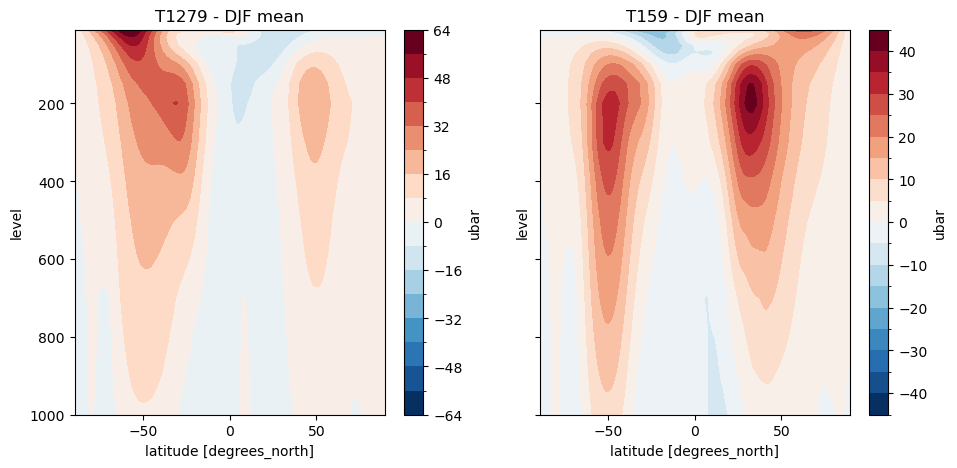

In [11]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(11,5))

t1279_djf.ubar.mean(('time', 'ens_ax')).plot.contourf(levels=20, yincrease=False, ax=axes[0])
t159_djf.ubar.mean(('time', 'ens_ax')).plot.contourf(levels=20, yincrease=False, ax=axes[1])
axes[0].set_title('T1279 - DJF mean')
axes[1].set_title('T159 - DJF mean')
plt.show()

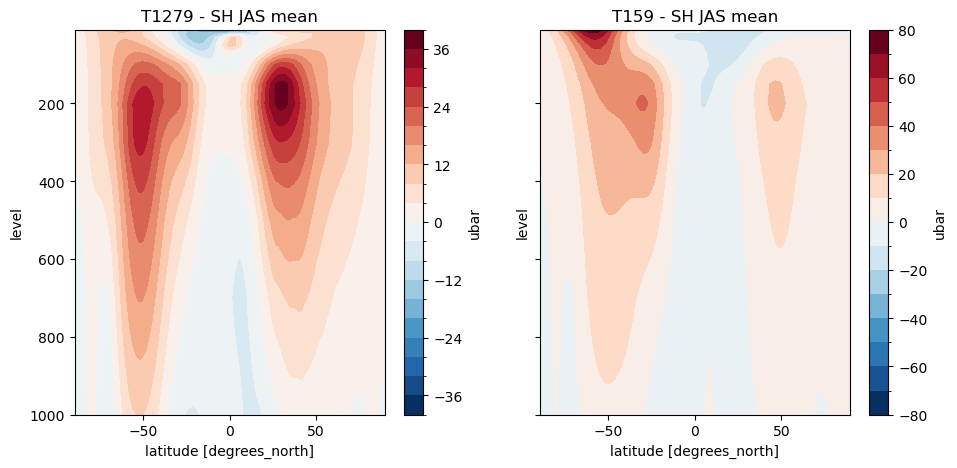

In [ ]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(11,5))

models_jas['OpenIFS-T1279'].ubar.mean(('time', 'ens_ax')).plot.contourf(levels=20, yincrease=False, ax=axes[0])
models_jas['OpenIFS-T159'].ubar.mean(('time', 'ens_ax')).plot.contourf(levels=20, yincrease=False, ax=axes[1])
axes[0].set_title('T1279 - JAS mean')
axes[1].set_title('T159 - JAS mean')
plt.show()

# Plot lat lon map

In [14]:
t1279_djf

<xarray.Dataset>
Dimensions:  (time: 1, ens_ax: 99, level: 13, lat: 160, lon: 960)
Coordinates:
  * level    (level) float64 1e+03 700.0 500.0 400.0 ... 50.0 30.0 20.0 10.0
  * lon      (lon) float64 0.0 0.375 0.75 1.125 1.5 ... 358.5 358.9 359.2 359.6
  * time     (time) object 2000-12-01 00:00:00
  * lat      (lat) float64 -89.44 -88.31 -87.19 -86.06 ... 87.19 88.31 89.44
Dimensions without coordinates: ens_ax
Data variables:
    epfy     (time, ens_ax, level, lat) float64 dask.array<chunksize=(1, 99, 13, 160), meta=np.ndarray>
    epfz     (time, ens_ax, level, lat) float64 dask.array<chunksize=(1, 99, 13, 160), meta=np.ndarray>
    ua       (time, ens_ax, level, lat, lon) float32 dask.array<chunksize=(1, 99, 13, 160, 960), meta=np.ndarray>
    divFy    (time, ens_ax, level, lat) float64 dask.array<chunksize=(1, 99, 13, 160), meta=np.ndarray>
    ubar     (time, ens_ax, level, lat) float32 dask.array<chunksize=(1, 99, 13, 160), meta=np.ndarray>

In [15]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Load your dataset (replace with your file path and variable names)
winds500 = t1279_djf['ua'].sel(level=500).mean(('time', 'ens_ax'))  # Replace with your variable name
winds500_low_res = winds500.coarsen(lat=2, lon=8, boundary="trim").mean()
winds500_low_res

<xarray.DataArray 'ua' (lat: 80, lon: 120)>
dask.array<mean_agg-aggregate, shape=(80, 120), dtype=float32, chunksize=(80, 120), chunktype=numpy.ndarray>
Coordinates:
    level    float64 500.0
  * lon      (lon) float64 1.312 4.312 7.312 10.31 ... 349.3 352.3 355.3 358.3
  * lat      (lat) float64 -88.88 -86.62 -84.38 -82.12 ... 84.38 86.62 88.88

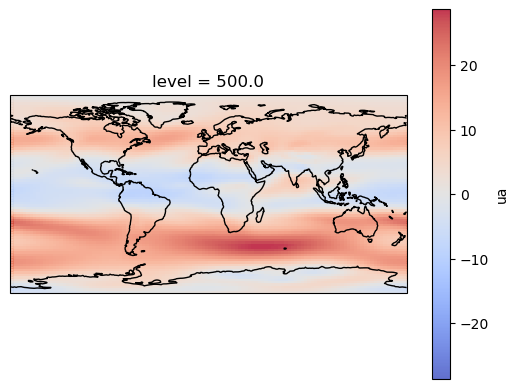

In [16]:
# tell plt to use a certain projection
ax = plt.axes(projection=ccrs.PlateCarree())
# tell plot to add coastlines
ax.coastlines(resolution='110m')

# Overlay surface temperature
winds500_low_res.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    alpha=0.8,  # Transparency for blending
    add_colorbar=True
)

plt.show()

In [17]:
# Load your dataset (replace with your file path and variable names)
winds500_t159 = t159_djf['ua'].sel(level=500).mean(('time', 'ens_ax')).load()  # Replace with your variable name

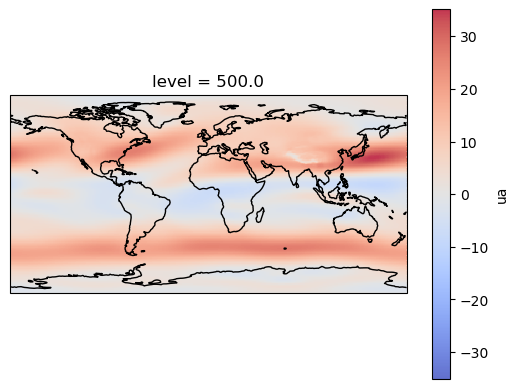

In [18]:
# tell plt to use a certain projection
ax = plt.axes(projection=ccrs.PlateCarree())
# tell plot to add coastlines
ax.coastlines(resolution='110m')

# Overlay surface temperature
winds500_t159.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    alpha=0.8,  # Transparency for blending
    add_colorbar=True
)

plt.show()